### Topic Modeling

In [1]:
#load libraries
import pandas as pd

# NLTK
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# Gensim
from gensim.models import LdaModel
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary

#for plotting
import matplotlib.pyplot as plt


c:\Users\samael\AppData\Local\Programs\Python\Python39\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [3]:
#load cleaned data from csv
df = pd.read_csv('data/cleaned_data.csv',dtype=str)
df['amount'].astype(float, errors='ignore')

print(df.head())
print(f"shape is: {df.shape}")

  award_id                                              title    amount  \
0  0000009     Design of Cutting Tools for High Speed Milling  280000.0   
1  0000026  A Novel Ultrasonic Cooling Concept for Microel...  292026.0   
2  0000027  Development of a Wireless Sensor to Detect Cra...  238000.0   
3  0000031  Development of Link-to-Column Connections for ...  285000.0   
4  0000033  Integrated study of source, path, and site eff...   84000.0   

                                            abstract  \
0  this project will focus development new cuttin...   
1  the purpose the proposed work design novel coo...   
2  &lt;br/&gt;the objective this research project...   
3  &lt;br/&gt;engelhardt&lt;br/&gt;the objective ...   
4  the kocaeli, turkey, earthquake (m=.) august w...   

                                   division  
0  Div Of Civil, Mechanical, & Manufact Inn  
1     Div Of Electrical, Commun & Cyber Sys  
2  Div Of Civil, Mechanical, & Manufact Inn  
3  Div Of Civil, Mechanical,

In [4]:
df['division'].value_counts()

Division Of Mathematical Sciences                          18567
Translational Impacts                                      12728
Division Of Computer and Network Systems                   12199
Div Of Civil, Mechanical, & Manufact Inn                   11904
Division Of Earth Sciences                                 11573
                                                           ...  
Division of Behavioral and Cognitive Sciences                  1
National Center for Science and Engineering Statistics.        1
Division Of Design & Manufacturing Innov                       1
Division Of Polar Progrms                                      1
Arctic Sciences Division                                       1
Name: division, Length: 73, dtype: int64

In [5]:
#zoom in on one division
division = 'Div Of Civil, Mechanical, & Manufact Inn'
# division = 'Division Of Mathematical Sciences'

#filter data by division
data = df[df['division']==division]

In [6]:
#add year column
data['year'] = data.loc[:,"award_id"].apply(lambda x: f"20{x[:2]}")

<ipython-input-6-3b36e28d5732>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data.loc[:,"award_id"].apply(lambda x: f"20{x[:2]}")


In [7]:
#reset index
data.reset_index(inplace=True,drop=True)

We will preprocess the entire corpus and handle the representation (BoW) in a single go. That way, we won't have to worry about inconsistent representations among models.

In [8]:
#convert to list
text_data = data['abstract'].tolist()

In [9]:
# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(text_data)):
    text_data[idx] = text_data[idx].lower()  
    text_data[idx] = tokenizer.tokenize(text_data[idx])  # Split into words.

#remove numbers
text_data = [[token for token in doc if not token.isnumeric()] for doc in text_data]

#remove words that are only one character.
text_data = [[token for token in doc if len(token) > 1] for doc in text_data]

In [10]:
#look at first document
text_data[0]

['this',
 'project',
 'will',
 'focus',
 'development',
 'new',
 'cutting',
 'tool',
 'designs',
 'allow',
 'increases',
 'high',
 'speed',
 'machining',
 'hsm',
 'productivity',
 'the',
 'researchers',
 'will',
 'investigate',
 'new',
 'method',
 'increasing',
 'the',
 'damping',
 'the',
 'tool',
 'body',
 'through',
 'creation',
 'internal',
 'features',
 'which',
 'will',
 'dissipate',
 'energy',
 'through',
 'friction',
 'during',
 'tool',
 'vibration',
 'these',
 'features',
 'will',
 'designed',
 'utilize',
 'the',
 'high',
 'centripetal',
 'accelerations',
 'experienced',
 'during',
 'the',
 'high',
 'spindle',
 'speeds',
 'used',
 'hsm',
 'dramatically',
 'increase',
 'the',
 'resulting',
 'energy',
 'dissipation',
 'this',
 'centrifugal',
 'damping',
 'will',
 'provide',
 'significant',
 'increases',
 'the',
 'dynamic',
 'stiffness',
 'the',
 'tool',
 'and',
 'result',
 'direct',
 'productivity',
 'improvements',
 'hsm',
 'the',
 'researchers',
 'will',
 'also',
 'investigate'

In [11]:
lemmatizer = WordNetLemmatizer()
text_data = [[lemmatizer.lemmatize(token) for token in doc] for doc in text_data]

In [13]:
#remove stop words
stop_words = stopwords.words('english')

#extend stop words to corpus specific words
extra_stop_words = ['award','project','research',
                    'investigator','investigators',
                    'investigate','investigates','investigated','investigating',
                    'proposal','proposals','abstract',
                    'nsf','funded','funding',
                    'program','programs',
                    'support','supports','supported',
                    'br','lt','gt','amp','quot','div','lf', #html tags
                    'pi','pis', #principal investigator]
                    'researcher','researchers',
                    'work','works','working',
                    'study','studies','studying',
                    'develop','develops','developed','developing','development',
                    'consider','considered','considering',
                    'include','includes','including',
                    'provide','provides','provided',
                    'use','uses','used',
                    'design','designs','designed','designing',
                    'demonstrate','demonstrates','demonstrated','demonstrating',
                    'result','results','resulted','resulting',
                    'show','shows','showed','showing',
                    'understand','understands','understood','understanding',
                    'determine','determines','determined','determining',
                    'find','finds','found','finding',
                    'identify','identifies','identified','identifying',
                    'evaluate','evaluates','evaluated','evaluating',
                    'examine','examines','examined','examining',
                    'explore','explores','explored','exploring',
                    'new','using','high','low','large','small','different','based',
                    'significant','important','possible','potential','novel',
                    'approach','approaches','approached','approaching',
                    'method','methods',
                    'include','includes','including',
                    'also','well','many','much','several','various','different',
                    'engineering','engineer','engineers','engineered',
                    'system','systems','systematic',
                    'model','models','modeling','modelled','modelled',
                    'analysis','analyse','analyses','analysed','analysing',
                    'method','methods','methodology','methodologies',
                    'specific','specifically',
                    'impact','impacts','impacted','impacting',
                    'profound','profoundly',
                    'significant','significantly',
                    'although','though','however','yet','still','nevertheless',
                    'thus','therefore','hence','consequently',
                    'first','second','third','fourth','fifth','sixth','seventh','eighth','ninth','tenth',
                    'have','has','having','had','ha',
                    'problem','problems',
                    'science','sciences','scientific',
                    'scientist','scientists',
                    'knowledge','knowledges','knowledgable',
]
stop_words.extend(extra_stop_words)

#much faster to convert to set
stop_words = set(stop_words)

In [14]:
#remove stop words
text_data = [[token for token in doc if token not in stop_words] for doc in text_data]

In [15]:
text_data[35]

['material',
 'failure',
 'strain',
 'rate',
 'batra',
 'virginia',
 'polytechnic',
 'institute',
 'state',
 'university',
 'hyperbolic',
 'heat',
 'equation',
 'along',
 'equation',
 'expressing',
 'balance',
 'mass',
 'linear',
 'momentum',
 'moment',
 'momentum',
 'thermoviscoplastic',
 'material',
 'delineate',
 'initiation',
 'propagation',
 'adiabatic',
 'shear',
 'band',
 'asbs',
 'strain',
 'rate',
 'deformation',
 'material',
 'asb',
 'narrow',
 'region',
 'intense',
 'plastic',
 'deformation',
 'usually',
 'precedes',
 'ductile',
 'failure',
 'metal',
 'polymer',
 'deformed',
 'strain',
 'rate',
 'heat',
 'generated',
 'due',
 'plastic',
 'deformation',
 'material',
 'heat',
 'conduction',
 'thermal',
 'stress',
 'induced',
 'accounted',
 'finite',
 'element',
 'mesh',
 'refined',
 'adaptively',
 'time',
 'increment',
 'integrate',
 'coupled',
 'nonlinear',
 'ordinary',
 'differential',
 'equation',
 'obtained',
 'galerkin',
 'approximation',
 'governing',
 'equation',
 'adju

In [16]:
#look at most frequent words in data
from collections import Counter
from itertools import chain
from nltk import FreqDist

#flatten list of lists
all_words = list(chain(*text_data))


In [17]:
all_words_freq = FreqDist(all_words)

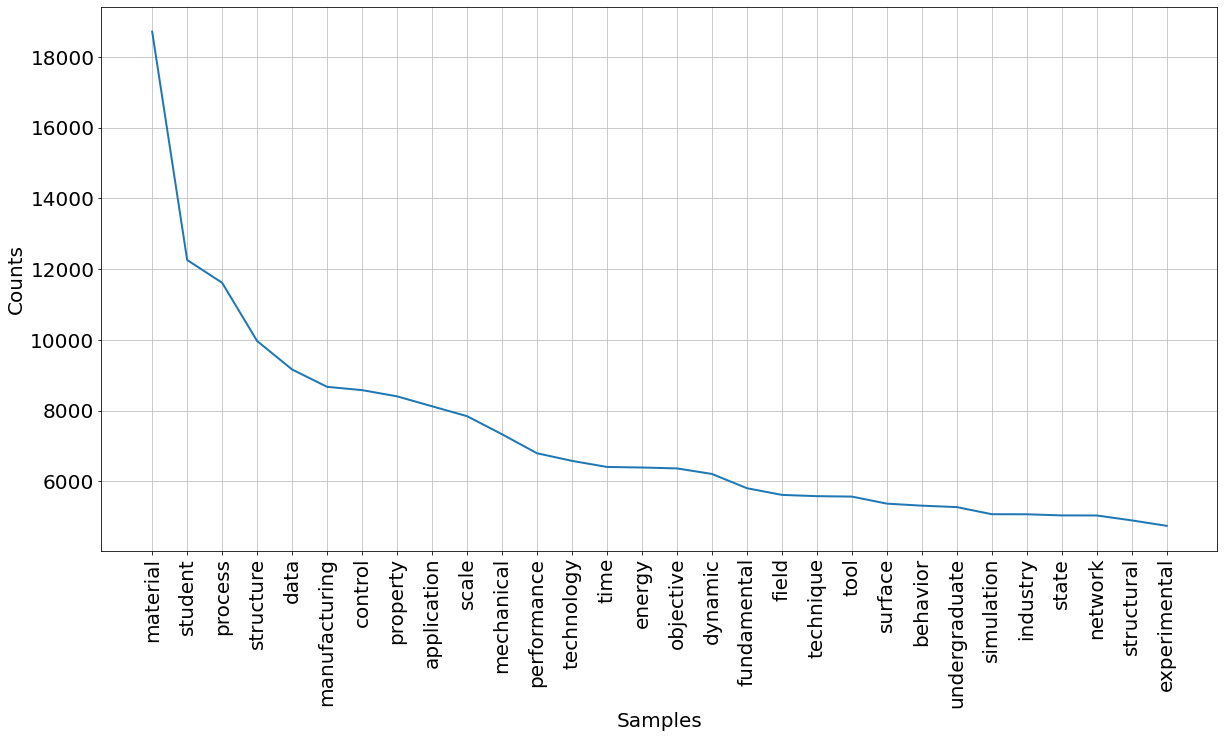

In [48]:
#plot most frequent words
plt.figure(figsize=(20,10))
all_words_freq.plot(30, cumulative=False)

#increase font size for plot
plt.rcParams.update({'font.size': 15})

In [23]:
#bigrams and trigrams. let's us capture useful phrases such as 'machine_learning' or 'quantum_computing'
bigram = Phrases(text_data, min_count=5, threshold=50) 
trigram = Phrases(bigram[text_data], threshold=50) 

# exporting trained models for bigrams and trigrams. faster.
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)


2023-07-26 15:06:24,856 : INFO : collecting all words and their counts
2023-07-26 15:06:24,856 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2023-07-26 15:06:27,662 : INFO : PROGRESS: at sentence #10000, processed 1716035 words and 775580 word types
2023-07-26 15:06:28,301 : INFO : collected 910923 word types from a corpus of 2146293 words (unigram + bigrams) and 11904 sentences
2023-07-26 15:06:28,301 : INFO : using 910923 counts as vocab in Phrases<0 vocab, min_count=5, threshold=50, max_vocab_size=40000000>
c:\Users\samael\AppData\Local\Programs\Python\Python39\lib\site-packages\gensim\models\phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
2023-07-26 15:06:28,317 : INFO : collecting all words and their counts
2023-07-26 15:06:28,325 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2023-07-26 15:

In [26]:
#see example of bigrams + trigrams
print([x for x in bigram_mod[text_data[7]] if '_' in x])

print([x for x in trigram_mod[text_data[7]] if '_' in x])

['titanium_alloy', 'nickel_superalloys', 'taking_account', 'thermo_mechanical', 'thermo_mechanical', 'titanium_alloy', 'aircraft_automobile', 'woman_minority']
['shear_localization', 'titanium_alloy', 'nickel_superalloys', 'taking_account', 'shear_localization', 'thermo_mechanical', 'thermo_mechanical', 'speed_spindle', 'titanium_alloy', 'aircraft_automobile', 'graduate_undergraduate', 'woman_minority']


In [27]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(text_data)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

2023-07-26 15:07:25,928 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2023-07-26 15:07:27,338 : INFO : adding document #10000 to Dictionary(27458 unique tokens: ['acceleration', 'acceptance', 'achievable', 'allow', 'area']...)
2023-07-26 15:07:27,678 : INFO : built Dictionary(29704 unique tokens: ['acceleration', 'acceptance', 'achievable', 'allow', 'area']...) from 11904 documents (total 2146293 corpus positions)
2023-07-26 15:07:27,709 : INFO : discarding 23621 tokens: [('centrifugal', 10), ('centripetal', 1), ('cutter', 9), ('expects', 14), ('hsm', 2), ('undulating', 5), ('unequal', 4), ('coil', 16), ('eleven', 10), ('epicentral', 4)]...
2023-07-26 15:07:27,709 : INFO : keeping 6083 tokens which were in no less than 20 and no more than 5952 (=50.0%) documents
2023-07-26 15:07:27,717 : DEBUG : rebuilding dictionary, shrinking gaps
2023-07-26 15:07:27,725 : INFO : resulting dictionary: Dictionary(6083 unique tokens: ['acceleration', 'acceptance', 'achievable', 'allow'

In [28]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in text_data]

In [29]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 6083
Number of documents: 11904


In [30]:
ntopics = 50
#train model on portion of the corpus
def train_model(corpus, id2word, num_topics=ntopics,):
    lda = LdaModel(
            corpus=corpus,
            id2word=id2word,
            chunksize=2000,
            alpha='auto',
            eta='auto',
            iterations=500,
            num_topics=num_topics,
            passes=20,
            eval_every=1
        )
    return lda

In [31]:
#split corpus by year
corpus_by_year = {}
for year in data['year'].unique():
    corpus_by_year[year] = [corpus[i] for i in data[data['year']==year].index]

In [32]:
# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

In [33]:
#train model on a single year as a test #check for convergence. if it doesn't converge, increase iterations, extend stopwords, etc.
model = train_model(corpus_by_year['2019'],id2word)

2023-07-26 15:08:10,624 : INFO : using autotuned alpha, starting with [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
2023-07-26 15:08:10,632 : INFO : using serial LDA version on this node
2023-07-26 15:08:10,666 : INFO : running online (multi-pass) LDA training, 50 topics, 20 passes over the supplied corpus of 613 documents, updating model once every 613 documents, evaluating perplexity every 613 documents, iterating 500x with a convergence threshold of 0.001000
2023-07-26 15:08:10,680 : DEBUG : bound: at document #0
2023-07-26 15:08:25,066 : INFO : -15.104 per-word bound, 35217.5 perplexity estimate based on a held-out corpus of 613 documents with 128146 words
2023-07-26 15:08:25,066 : INFO : PROGRESS: pass 0, at document #613/613
2023

In [35]:
#look at topics
[x[1] for x in model.show_topics(num_topics=ntopics, num_words=10, log=False, formatted=True)]


['0.020*"control" + 0.016*"manufacturing" + 0.011*"process" + 0.010*"time" + 0.009*"algorithm" + 0.009*"data" + 0.008*"real" + 0.008*"framework" + 0.007*"learning" + 0.006*"search"',
 '0.031*"material" + 0.023*"magnetic" + 0.020*"shape" + 0.018*"actuation" + 0.015*"soft" + 0.013*"memory" + 0.010*"device" + 0.010*"polymer" + 0.009*"particle" + 0.008*"active"',
 '0.013*"material" + 0.010*"gel" + 0.008*"property" + 0.007*"mechanical" + 0.007*"dynamic" + 0.007*"process" + 0.007*"response" + 0.006*"dna" + 0.006*"robotic" + 0.006*"structure"',
 '0.018*"data" + 0.015*"control" + 0.009*"cloud" + 0.009*"learning" + 0.007*"process" + 0.007*"machine" + 0.007*"cnc" + 0.006*"manufacturing" + 0.006*"subsurface" + 0.005*"performance"',
 '0.015*"data" + 0.013*"soft" + 0.013*"material" + 0.010*"learning" + 0.010*"test" + 0.010*"machine" + 0.009*"mechanic" + 0.009*"soil" + 0.008*"particle" + 0.008*"pressure"',
 '0.021*"structural" + 0.018*"building" + 0.016*"earthquake" + 0.012*"performance" + 0.011*"st

In [253]:
#### run this once if you are happy with the model.
# #perform the training on full dataset
# lda_by_year = {}
# for year in sorted(data['year'].unique()):
#     print(f"training model for year: {year}")
#     lda_by_year[year] = train_model(corpus_by_year[year],id2word,num_topics=50)

#     print(f"saving model for year: {year}")
#     lda_by_year[year].save(f'models/{division}_{year}.model')

# #save dictionary
# dictionary.save_as_text('models/dictionary.txt')

2023-07-09 19:17:13,028 : INFO : using autotuned alpha, starting with [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
2023-07-09 19:17:13,030 : INFO : using serial LDA version on this node
2023-07-09 19:17:13,054 : INFO : running online (multi-pass) LDA training, 50 topics, 20 passes over the supplied corpus of 430 documents, updating model once every 430 documents, evaluating perplexity every 430 documents, iterating 500x with a convergence threshold of 0.001000


training model for year: 2000


2023-07-09 19:17:17,095 : INFO : -22.463 per-word bound, 5782369.8 perplexity estimate based on a held-out corpus of 430 documents with 56508 words
2023-07-09 19:17:17,096 : INFO : PROGRESS: pass 0, at document #430/430
2023-07-09 19:17:20,553 : INFO : optimized alpha [0.018215284, 0.018161025, 0.018061003, 0.018625332, 0.01816634, 0.017958395, 0.018314274, 0.018370187, 0.018575517, 0.018366108, 0.018318811, 0.018668639, 0.018315537, 0.018466305, 0.018061044, 0.017856752, 0.018366706, 0.018162087, 0.018266162, 0.018010989, 0.01990086, 0.01806106, 0.018367171, 0.018729309, 0.018674903, 0.018111961, 0.01862697, 0.018468998, 0.018163284, 0.01841729, 0.018574178, 0.018676998, 0.018418606, 0.018726895, 0.01826469, 0.018161742, 0.018061467, 0.018673647, 0.018060153, 0.018159894, 0.019088874, 0.018260024, 0.01821565, 0.018315004, 0.018164786, 0.019187681, 0.018520808, 0.018060872, 0.018571682, 0.017907498]
2023-07-09 19:17:20,572 : INFO : topic #15 (0.018): 0.051*"control" + 0.037*"motion" + 

saving model for year: 2000
training model for year: 2001


2023-07-09 19:17:49,628 : INFO : -26.704 per-word bound, 109307733.2 perplexity estimate based on a held-out corpus of 308 documents with 42723 words
2023-07-09 19:17:49,628 : INFO : PROGRESS: pass 0, at document #308/308
2023-07-09 19:17:51,906 : INFO : optimized alpha [0.018626664, 0.01977633, 0.018337933, 0.01812406, 0.019268205, 0.018125318, 0.018410765, 0.018910643, 0.018837532, 0.018122444, 0.018054195, 0.018697854, 0.018483726, 0.018338786, 0.018338399, 0.01819711, 0.01804592, 0.017910339, 0.018338997, 0.019133655, 0.01819513, 0.017911185, 0.018410757, 0.018340532, 0.01905533, 0.018911026, 0.017910013, 0.017982293, 0.018054435, 0.017909873, 0.018411035, 0.01833603, 0.017838456, 0.018554136, 0.018125592, 0.018481437, 0.017911537, 0.018126167, 0.018336374, 0.018908799, 0.018267829, 0.018269593, 0.018622218, 0.017767772, 0.017767772, 0.01798066, 0.018340394, 0.018341098, 0.018124662, 0.01848327]
2023-07-09 19:17:51,922 : INFO : topic #43 (0.018): 0.000*"hydration" + 0.000*"fly" + 0

saving model for year: 2001
training model for year: 2002


2023-07-09 19:18:14,023 : INFO : -19.723 per-word bound, 865643.0 perplexity estimate based on a held-out corpus of 472 documents with 71376 words
2023-07-09 19:18:14,024 : INFO : PROGRESS: pass 0, at document #472/472
2023-07-09 19:18:18,476 : INFO : optimized alpha [0.01825012, 0.018296095, 0.018987788, 0.019325508, 0.018529244, 0.01810651, 0.018060867, 0.018013773, 0.018342592, 0.018248212, 0.018338878, 0.018474737, 0.018244999, 0.0191894, 0.018107247, 0.01796911, 0.01782948, 0.018062433, 0.0182492, 0.017921414, 0.018478502, 0.018062374, 0.018481243, 0.018388864, 0.018668398, 0.018763253, 0.01838851, 0.01829453, 0.01815226, 0.018064013, 0.01852761, 0.018386623, 0.018667128, 0.01834081, 0.018343702, 0.018200465, 0.017969938, 0.01806051, 0.018104663, 0.018904466, 0.018763747, 0.018251866, 0.017735813, 0.019041888, 0.018063676, 0.017969599, 0.019700577, 0.018202232, 0.018248782, 0.018612886]
2023-07-09 19:18:18,496 : INFO : topic #42 (0.018): 0.000*"hydration" + 0.000*"fly" + 0.000*"ur

saving model for year: 2002
training model for year: 2003


2023-07-09 19:18:56,203 : INFO : -18.786 per-word bound, 451904.2 perplexity estimate based on a held-out corpus of 505 documents with 78439 words
2023-07-09 19:18:56,204 : INFO : PROGRESS: pass 0, at document #505/505
2023-07-09 19:19:02,021 : INFO : optimized alpha [0.01833918, 0.018516965, 0.018033465, 0.017990606, 0.018688137, 0.017945405, 0.018737506, 0.0181223, 0.01803233, 0.018208181, 0.018646723, 0.018423183, 0.018644512, 0.018252535, 0.01829889, 0.018210942, 0.018033355, 0.018600717, 0.018165147, 0.018603176, 0.017948078, 0.019083982, 0.018163675, 0.018119426, 0.019519161, 0.017860273, 0.01820858, 0.019078257, 0.0182074, 0.01820866, 0.0180778, 0.018209595, 0.01877838, 0.01829774, 0.018253654, 0.018862754, 0.019561369, 0.018075775, 0.018165592, 0.018296117, 0.01812288, 0.017946888, 0.018296156, 0.017991409, 0.018249178, 0.01803559, 0.018427107, 0.017990716, 0.018643945, 0.018777799]
2023-07-09 19:19:02,038 : INFO : topic #25 (0.018): 0.035*"membrane" + 0.012*"nanoporous" + 0.01

saving model for year: 2003
training model for year: 2004


2023-07-09 19:19:42,356 : INFO : -20.503 per-word bound, 1486050.8 perplexity estimate based on a held-out corpus of 431 documents with 66389 words
2023-07-09 19:19:42,357 : INFO : PROGRESS: pass 0, at document #431/431
2023-07-09 19:19:46,730 : INFO : optimized alpha [0.018598981, 0.018289877, 0.019063337, 0.018187402, 0.01859703, 0.01818984, 0.017981984, 0.018750513, 0.018391948, 0.018546479, 0.01844141, 0.018650511, 0.018136851, 0.018854478, 0.017932843, 0.018240068, 0.019318912, 0.018544463, 0.018547697, 0.018187072, 0.01834256, 0.018289668, 0.01844398, 0.018598385, 0.01849262, 0.018085755, 0.018084567, 0.018188732, 0.018290887, 0.018237235, 0.018135749, 0.018188113, 0.018188085, 0.018390238, 0.018290073, 0.018341132, 0.01793178, 0.018442987, 0.018291477, 0.017933674, 0.01859842, 0.01828571, 0.017982293, 0.018496105, 0.018645624, 0.017982172, 0.01808619, 0.018086424, 0.018593766, 0.018593349]
2023-07-09 19:19:46,747 : INFO : topic #36 (0.018): 0.017*"seismic" + 0.012*"control" + 0.

saving model for year: 2004
training model for year: 2005


2023-07-09 19:20:21,121 : INFO : -19.950 per-word bound, 1012816.2 perplexity estimate based on a held-out corpus of 473 documents with 69873 words
2023-07-09 19:20:21,122 : INFO : PROGRESS: pass 0, at document #473/473
2023-07-09 19:20:25,822 : INFO : optimized alpha [0.018216, 0.01877418, 0.017935647, 0.018262196, 0.019049425, 0.017842615, 0.018209852, 0.017982382, 0.017841205, 0.018446703, 0.017987432, 0.018451046, 0.017934881, 0.01816815, 0.018119508, 0.018215511, 0.01868475, 0.017889148, 0.018444864, 0.018123457, 0.017982, 0.017982954, 0.01803079, 0.01825989, 0.018680314, 0.019196345, 0.018263388, 0.018909197, 0.018398821, 0.01863411, 0.0182144, 0.018074721, 0.018119836, 0.020312319, 0.018072005, 0.019654807, 0.018075733, 0.018029466, 0.01854024, 0.017936371, 0.01886808, 0.018910773, 0.018072996, 0.018077275, 0.018354354, 0.018446773, 0.018728182, 0.0187255, 0.018259844, 0.01830913]
2023-07-09 19:20:25,841 : INFO : topic #5 (0.018): 0.031*"drought" + 0.029*"plan" + 0.025*"cell" + 

saving model for year: 2005
training model for year: 2006


2023-07-09 19:21:02,551 : INFO : -20.197 per-word bound, 1201581.8 perplexity estimate based on a held-out corpus of 471 documents with 68295 words
2023-07-09 19:21:02,551 : INFO : PROGRESS: pass 0, at document #471/471
2023-07-09 19:21:07,086 : INFO : optimized alpha [0.018451033, 0.019383872, 0.018030766, 0.018168038, 0.018171685, 0.0180288, 0.018073067, 0.018216826, 0.018168442, 0.018216101, 0.018446112, 0.01844817, 0.01849602, 0.018028786, 0.018121775, 0.018402332, 0.018215915, 0.019153846, 0.01872982, 0.017842632, 0.018542849, 0.01844867, 0.018356295, 0.018544404, 0.018310713, 0.017962515, 0.018780444, 0.018121315, 0.01807496, 0.018121377, 0.018356092, 0.017982557, 0.018495968, 0.019011382, 0.018549144, 0.018870577, 0.018027766, 0.018495336, 0.018217487, 0.01821917, 0.018639995, 0.018264085, 0.017888986, 0.01835575, 0.018871292, 0.01826241, 0.018319434, 0.018076072, 0.018311426, 0.019194134]
2023-07-09 19:21:07,103 : INFO : topic #19 (0.018): 0.018*"competition" + 0.012*"plasma" +

saving model for year: 2006
training model for year: 2007


2023-07-09 19:21:42,714 : INFO : -19.301 per-word bound, 646134.0 perplexity estimate based on a held-out corpus of 492 documents with 74409 words
2023-07-09 19:21:42,714 : INFO : PROGRESS: pass 0, at document #492/492
2023-07-09 19:21:47,953 : INFO : optimized alpha [0.018713187, 0.0189843, 0.0179983, 0.019161087, 0.017954236, 0.018668182, 0.019070646, 0.018043038, 0.018356336, 0.018268123, 0.017996747, 0.017952736, 0.018714517, 0.018131316, 0.01799722, 0.018354382, 0.01795073, 0.018537225, 0.018087221, 0.018443154, 0.01831297, 0.017997302, 0.018215876, 0.01844568, 0.018356394, 0.01849339, 0.018043611, 0.01822086, 0.018399559, 0.017953612, 0.018667188, 0.018310122, 0.017950961, 0.018531978, 0.018399274, 0.018356558, 0.018309612, 0.019164875, 0.018040735, 0.018039536, 0.0179538, 0.017998058, 0.017863374, 0.018176874, 0.018132549, 0.018221205, 0.01867113, 0.018937774, 0.019610053, 0.01858197]
2023-07-09 19:21:47,971 : INFO : topic #42 (0.018): 0.016*"technology" + 0.015*"temperature" + 

saving model for year: 2007
training model for year: 2008


2023-07-09 19:22:27,613 : INFO : -18.229 per-word bound, 307164.9 perplexity estimate based on a held-out corpus of 582 documents with 83376 words
2023-07-09 19:22:27,614 : INFO : PROGRESS: pass 0, at document #582/582
2023-07-09 19:22:32,745 : INFO : optimized alpha [0.018160345, 0.01857749, 0.017933676, 0.018653668, 0.018958008, 0.018387688, 0.018763738, 0.018652532, 0.017857688, 0.018386405, 0.01804465, 0.017971361, 0.017970592, 0.018159011, 0.018728001, 0.017858174, 0.018880052, 0.018236576, 0.01906685, 0.017969614, 0.01804843, 0.018009538, 0.018158138, 0.019261226, 0.018124154, 0.01804716, 0.019148929, 0.018010546, 0.018276064, 0.01819557, 0.018235873, 0.01861426, 0.018236449, 0.018651305, 0.019144166, 0.017895628, 0.017934043, 0.018312447, 0.018313723, 0.018726122, 0.018236475, 0.018274458, 0.01823893, 0.018008502, 0.01808332, 0.018691782, 0.018467281, 0.01778261, 0.018463442, 0.017896734]
2023-07-09 19:22:32,763 : INFO : topic #15 (0.018): 0.018*"point" + 0.017*"surface" + 0.011

saving model for year: 2008
training model for year: 2009


2023-07-09 19:23:18,665 : INFO : -16.474 per-word bound, 91019.3 perplexity estimate based on a held-out corpus of 703 documents with 103788 words
2023-07-09 19:23:18,667 : INFO : PROGRESS: pass 0, at document #703/703
2023-07-09 19:23:25,356 : INFO : optimized alpha [0.018016499, 0.017861977, 0.019867294, 0.018049097, 0.018675964, 0.01861163, 0.018205423, 0.019551568, 0.018832786, 0.01839198, 0.018364782, 0.018018987, 0.017830763, 0.018204715, 0.018643076, 0.018989636, 0.019019684, 0.01792439, 0.01820709, 0.018394038, 0.018299943, 0.017985657, 0.018049309, 0.018080814, 0.018079868, 0.017924175, 0.018142318, 0.017986197, 0.019333327, 0.018206248, 0.018267537, 0.01864425, 0.018109854, 0.019398281, 0.018143488, 0.018236108, 0.018520301, 0.01814161, 0.018832074, 0.018017845, 0.017860807, 0.018081792, 0.01814367, 0.018704955, 0.01823638, 0.018080207, 0.018361967, 0.01808006, 0.018393649, 0.018270295]
2023-07-09 19:23:25,374 : INFO : topic #12 (0.018): 0.014*"laser" + 0.012*"micro" + 0.011*

saving model for year: 2009
training model for year: 2010


2023-07-09 19:24:23,132 : INFO : -17.971 per-word bound, 256951.4 perplexity estimate based on a held-out corpus of 580 documents with 85865 words
2023-07-09 19:24:23,133 : INFO : PROGRESS: pass 0, at document #580/580
2023-07-09 19:24:28,798 : INFO : optimized alpha [0.018375149, 0.018224478, 0.018226108, 0.019554412, 0.018752445, 0.017920747, 0.01822549, 0.0184145, 0.018074047, 0.018034928, 0.017958475, 0.01803392, 0.017996537, 0.017996859, 0.01864435, 0.01811053, 0.018377807, 0.01830093, 0.018410513, 0.01875505, 0.018722516, 0.018181274, 0.018450705, 0.018184137, 0.018147498, 0.018033262, 0.018185783, 0.01841308, 0.018721517, 0.018646363, 0.018606663, 0.01909928, 0.017920827, 0.018530367, 0.018072762, 0.018339112, 0.018528663, 0.019592825, 0.018487465, 0.018071637, 0.018297963, 0.018148452, 0.018643348, 0.017919946, 0.018147906, 0.01818326, 0.01814899, 0.018224427, 0.017881718, 0.018378044]
2023-07-09 19:24:28,815 : INFO : topic #32 (0.018): 0.022*"uncertainty" + 0.021*"simulation" 

saving model for year: 2010
training model for year: 2011


2023-07-09 19:25:13,617 : INFO : -18.469 per-word bound, 362783.3 perplexity estimate based on a held-out corpus of 542 documents with 81168 words
2023-07-09 19:25:13,618 : INFO : PROGRESS: pass 0, at document #542/542
2023-07-09 19:25:18,663 : INFO : optimized alpha [0.01804782, 0.018700449, 0.018332914, 0.018213386, 0.018128978, 0.018376347, 0.018658945, 0.018087588, 0.01796987, 0.01837033, 0.018132113, 0.019147927, 0.018131003, 0.01882102, 0.01817298, 0.018371463, 0.01857651, 0.01833286, 0.017927147, 0.018411225, 0.018048579, 0.018418476, 0.018213216, 0.018329863, 0.017885322, 0.018412525, 0.018780023, 0.018903201, 0.018252132, 0.018212393, 0.01861642, 0.017965294, 0.018169545, 0.019267311, 0.018773358, 0.0180478, 0.018330015, 0.017887067, 0.018089404, 0.018620988, 0.017764749, 0.018497223, 0.018210245, 0.018652348, 0.018007757, 0.019269587, 0.01829549, 0.018905386, 0.018373633, 0.01780592]
2023-07-09 19:25:18,680 : INFO : topic #40 (0.018): 0.013*"magnetic" + 0.010*"mri" + 0.009*"c

saving model for year: 2011
training model for year: 2012


2023-07-09 19:26:01,638 : INFO : -18.063 per-word bound, 273913.6 perplexity estimate based on a held-out corpus of 551 documents with 84904 words
2023-07-09 19:26:01,639 : INFO : PROGRESS: pass 0, at document #551/551
2023-07-09 19:26:06,965 : INFO : optimized alpha [0.018593453, 0.018632224, 0.018031936, 0.017912205, 0.018032713, 0.019835621, 0.018073302, 0.018948937, 0.018030982, 0.018312158, 0.0186358, 0.018632844, 0.01775334, 0.018034609, 0.018312115, 0.018351289, 0.018190958, 0.018032808, 0.018392978, 0.018790983, 0.018271338, 0.017952764, 0.019637972, 0.0181497, 0.017913526, 0.018551446, 0.01907375, 0.017992878, 0.018670285, 0.018233776, 0.018793657, 0.018550124, 0.018069122, 0.017991828, 0.018591302, 0.018751465, 0.018951757, 0.017833572, 0.018314173, 0.01799106, 0.017872538, 0.018431434, 0.0187512, 0.018070716, 0.018033464, 0.018112108, 0.018153789, 0.01783187, 0.018192863, 0.018074205]
2023-07-09 19:26:06,983 : INFO : topic #12 (0.018): 0.018*"sector" + 0.018*"care" + 0.018*"

saving model for year: 2012
training model for year: 2013


2023-07-09 19:26:51,244 : INFO : -17.016 per-word bound, 132534.5 perplexity estimate based on a held-out corpus of 611 documents with 96475 words
2023-07-09 19:26:51,245 : INFO : PROGRESS: pass 0, at document #611/611
2023-07-09 19:26:56,968 : INFO : optimized alpha [0.018100075, 0.018529234, 0.01886083, 0.018354634, 0.01838726, 0.018384686, 0.018425424, 0.017991861, 0.017990803, 0.018136958, 0.018208902, 0.018643916, 0.01860598, 0.019111155, 0.018065026, 0.019037887, 0.018204084, 0.018999532, 0.018601798, 0.018826818, 0.018207263, 0.01817298, 0.018752888, 0.018135725, 0.017846523, 0.018137949, 0.017992854, 0.018133, 0.018029196, 0.018427538, 0.018098153, 0.018241076, 0.018132247, 0.018354328, 0.018822722, 0.018604686, 0.018136384, 0.018605517, 0.018136648, 0.01806442, 0.018172294, 0.018495418, 0.018856745, 0.0187847, 0.01813919, 0.018351214, 0.01792067, 0.01795579, 0.018173825, 0.017957347]
2023-07-09 19:26:56,985 : INFO : topic #24 (0.018): 0.019*"polymer" + 0.017*"surface" + 0.015*

saving model for year: 2013
training model for year: 2014


2023-07-09 19:27:45,182 : INFO : -15.885 per-word bound, 60500.7 perplexity estimate based on a held-out corpus of 616 documents with 112948 words
2023-07-09 19:27:45,183 : INFO : PROGRESS: pass 0, at document #616/616
2023-07-09 19:27:51,092 : INFO : optimized alpha [0.018103909, 0.018029427, 0.018176699, 0.018102376, 0.017746761, 0.018393964, 0.01835225, 0.018281328, 0.018248485, 0.018531945, 0.01796031, 0.018354245, 0.01817562, 0.018354842, 0.019893816, 0.018207153, 0.018964734, 0.018820727, 0.0187488, 0.017955597, 0.017996805, 0.018248701, 0.0186406, 0.017959774, 0.017961381, 0.017961947, 0.01832001, 0.019069094, 0.018819388, 0.018533505, 0.018603249, 0.018821776, 0.019178364, 0.01813985, 0.017996663, 0.017958434, 0.01831799, 0.01871058, 0.018999856, 0.018388692, 0.01778216, 0.018067608, 0.017888965, 0.018533012, 0.018030196, 0.017923376, 0.017850954, 0.018211583, 0.01770989, 0.018387074]
2023-07-09 19:27:51,110 : INFO : topic #48 (0.018): 0.020*"structural" + 0.017*"building" + 0.

saving model for year: 2014
training model for year: 2015


2023-07-09 19:28:50,172 : INFO : -14.986 per-word bound, 32447.8 perplexity estimate based on a held-out corpus of 706 documents with 130845 words
2023-07-09 19:28:50,173 : INFO : PROGRESS: pass 0, at document #706/706
2023-07-09 19:28:57,995 : INFO : optimized alpha [0.017915389, 0.018509293, 0.01797736, 0.017823147, 0.018886741, 0.018445607, 0.01857271, 0.018383436, 0.018134786, 0.018539969, 0.019164875, 0.018006321, 0.018818311, 0.018104078, 0.01835335, 0.018009387, 0.018290868, 0.019320449, 0.017915629, 0.018479066, 0.01841474, 0.018291656, 0.018254327, 0.019169671, 0.01835312, 0.018791063, 0.017666524, 0.017883427, 0.018102612, 0.018257882, 0.018352253, 0.0179784, 0.018758206, 0.017915871, 0.017997844, 0.018195366, 0.017852383, 0.019228004, 0.018510552, 0.017915836, 0.01939227, 0.018290188, 0.018134547, 0.018384203, 0.017791456, 0.018011017, 0.018197553, 0.018570999, 0.017916504, 0.018009245]
2023-07-09 19:28:58,016 : INFO : topic #26 (0.018): 0.020*"step" + 0.016*"process" + 0.01

saving model for year: 2015
training model for year: 2016


2023-07-09 19:30:11,231 : INFO : -15.443 per-word bound, 44551.8 perplexity estimate based on a held-out corpus of 632 documents with 121085 words
2023-07-09 19:30:11,231 : INFO : PROGRESS: pass 0, at document #632/632
2023-07-09 19:30:18,454 : INFO : optimized alpha [0.017971503, 0.018212449, 0.017970636, 0.018076042, 0.018143754, 0.018282061, 0.01916011, 0.01821157, 0.01825091, 0.01790203, 0.017936075, 0.018316314, 0.018285163, 0.018776868, 0.01825207, 0.018527256, 0.017829124, 0.017830743, 0.018215599, 0.018215261, 0.017934365, 0.017691402, 0.018564349, 0.01839041, 0.018076787, 0.017691864, 0.017899051, 0.01793583, 0.018002938, 0.019123463, 0.018729208, 0.018038178, 0.017864503, 0.018806227, 0.01842994, 0.019580502, 0.01853143, 0.018251112, 0.01776059, 0.018353704, 0.018810414, 0.018599177, 0.018040003, 0.018809564, 0.0196481, 0.01848644, 0.01835324, 0.018599853, 0.018180346, 0.018074464]
2023-07-09 19:30:18,471 : INFO : topic #25 (0.018): 0.018*"multi" + 0.016*"stage" + 0.011*"flow

saving model for year: 2016
training model for year: 2017


2023-07-09 19:31:20,796 : INFO : -15.861 per-word bound, 59498.7 perplexity estimate based on a held-out corpus of 568 documents with 113384 words
2023-07-09 19:31:20,797 : INFO : PROGRESS: pass 0, at document #568/568
2023-07-09 19:31:27,746 : INFO : optimized alpha [0.01834245, 0.017801173, 0.018071573, 0.018306687, 0.018619997, 0.017840404, 0.018265758, 0.01912256, 0.01811314, 0.018231269, 0.017878914, 0.018190997, 0.01963052, 0.017918045, 0.018186979, 0.01791824, 0.018037714, 0.0181111, 0.018035542, 0.017801525, 0.018112428, 0.018501278, 0.01897034, 0.017918102, 0.018221876, 0.017957862, 0.019507427, 0.019399637, 0.018388923, 0.018969603, 0.018035054, 0.018073004, 0.017840113, 0.01830485, 0.017841587, 0.018341959, 0.018150695, 0.018614255, 0.017955197, 0.018660877, 0.01814225, 0.018622093, 0.019161811, 0.018423907, 0.018771762, 0.018421037, 0.017917514, 0.01783857, 0.018735886, 0.018190147]
2023-07-09 19:31:27,763 : INFO : topic #34 (0.018): 0.033*"material" + 0.014*"two" + 0.013*"

saving model for year: 2017
training model for year: 2018


2023-07-09 19:32:26,285 : INFO : -17.573 per-word bound, 195043.5 perplexity estimate based on a held-out corpus of 434 documents with 89878 words
2023-07-09 19:32:26,286 : INFO : PROGRESS: pass 0, at document #434/434
2023-07-09 19:32:32,130 : INFO : optimized alpha [0.018505922, 0.01870277, 0.017999144, 0.017947642, 0.019213872, 0.017693792, 0.017998805, 0.018304223, 0.018353652, 0.01805076, 0.01926739, 0.01769428, 0.018099248, 0.018099641, 0.019627683, 0.017946012, 0.017741948, 0.018912964, 0.018046467, 0.019219695, 0.018198246, 0.018051662, 0.019119538, 0.019223832, 0.020027824, 0.017998293, 0.017897185, 0.01799898, 0.018104015, 0.017993748, 0.018000005, 0.018407037, 0.018303748, 0.018049266, 0.018046726, 0.017896546, 0.018302478, 0.018101145, 0.01901073, 0.017998362, 0.018709196, 0.01840328, 0.019326935, 0.017794842, 0.018959578, 0.018302986, 0.01784017, 0.018354123, 0.017695177, 0.017947763]
2023-07-09 19:32:32,147 : INFO : topic #11 (0.018): 0.023*"temperature" + 0.019*"fluid" +

saving model for year: 2018
training model for year: 2019


2023-07-09 19:33:23,125 : INFO : -15.104 per-word bound, 35227.0 perplexity estimate based on a held-out corpus of 613 documents with 128146 words
2023-07-09 19:33:23,125 : INFO : PROGRESS: pass 0, at document #613/613
2023-07-09 19:33:31,731 : INFO : optimized alpha [0.018343214, 0.019283433, 0.017947271, 0.018130396, 0.018125981, 0.01852459, 0.018306911, 0.018306965, 0.018526824, 0.01794335, 0.017731829, 0.018198408, 0.018448703, 0.019783774, 0.01906076, 0.018667178, 0.017839102, 0.018378736, 0.017768223, 0.01783833, 0.019391099, 0.018847832, 0.018307146, 0.017804295, 0.018162942, 0.018237237, 0.017982287, 0.01920933, 0.018489812, 0.017839534, 0.018057032, 0.019175345, 0.018091531, 0.017802484, 0.018808903, 0.018452097, 0.01780205, 0.017949682, 0.018483097, 0.018524539, 0.018417545, 0.018056983, 0.018562369, 0.018054107, 0.017767726, 0.017984144, 0.017694756, 0.018058266, 0.017836789, 0.019030172]
2023-07-09 19:33:31,748 : INFO : topic #46 (0.018): 0.013*"concrete" + 0.010*"mechanica

saving model for year: 2019
training model for year: 2020


2023-07-09 19:34:42,861 : INFO : -14.833 per-word bound, 29185.6 perplexity estimate based on a held-out corpus of 632 documents with 134427 words
2023-07-09 19:34:42,862 : INFO : PROGRESS: pass 0, at document #632/632
2023-07-09 19:34:51,474 : INFO : optimized alpha [0.017682279, 0.019256486, 0.018032555, 0.019190628, 0.019429859, 0.017752964, 0.017963493, 0.017785486, 0.018452132, 0.01778726, 0.017927172, 0.01824175, 0.017785462, 0.018277578, 0.018380567, 0.017788485, 0.019189773, 0.018103383, 0.018206876, 0.018448817, 0.018066792, 0.01824414, 0.017754083, 0.017891943, 0.018695869, 0.018486168, 0.018345391, 0.01810257, 0.018312026, 0.019006735, 0.018136915, 0.017928967, 0.018136043, 0.017857093, 0.018556036, 0.018206978, 0.018482579, 0.018306147, 0.018625082, 0.017823834, 0.018664164, 0.017962875, 0.017892834, 0.019184127, 0.01782044, 0.019468112, 0.018801998, 0.018450178, 0.018832857, 0.017961983]
2023-07-09 19:34:51,491 : INFO : topic #0 (0.018): 0.011*"metallic" + 0.010*"composite

saving model for year: 2020
training model for year: 2021


2023-07-09 19:36:06,041 : INFO : -15.595 per-word bound, 49478.7 perplexity estimate based on a held-out corpus of 552 documents with 118160 words
2023-07-09 19:36:06,042 : INFO : PROGRESS: pass 0, at document #552/552
2023-07-09 19:36:13,453 : INFO : optimized alpha [0.018824356, 0.017895238, 0.018054457, 0.019095138, 0.0186511, 0.01837261, 0.01801372, 0.018215634, 0.01785374, 0.01833401, 0.018451897, 0.018651454, 0.01781389, 0.018012788, 0.018133922, 0.017934354, 0.017814608, 0.019378448, 0.018052809, 0.018291252, 0.017815512, 0.017813878, 0.01805641, 0.017971572, 0.017928421, 0.018973503, 0.01817494, 0.018175062, 0.017654432, 0.018171303, 0.018538386, 0.018653555, 0.019055817, 0.018172745, 0.018297797, 0.017814044, 0.018177187, 0.01821175, 0.01797299, 0.018493421, 0.01813217, 0.018012276, 0.018454244, 0.01761456, 0.018295716, 0.017694414, 0.019898849, 0.017653707, 0.019456541, 0.020377845]
2023-07-09 19:36:13,470 : INFO : topic #43 (0.018): 0.044*"brain" + 0.037*"injury" + 0.034*"da

saving model for year: 2021


In [36]:
# #load in pretrained models - after training
lda_by_year = {}
for year in sorted(data['year'].unique()):
    print(f"loading model for year: {year}")
    lda_by_year[year] = LdaModel.load(f'models/{division}_{year}.model')

2023-07-26 15:11:19,138 : INFO : loading LdaModel object from models/Div Of Civil, Mechanical, & Manufact Inn_2000.model
2023-07-26 15:11:19,138 : DEBUG : {'uri': 'models/Div Of Civil, Mechanical, & Manufact Inn_2000.model', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'compression': None, 'transport_params': None}
2023-07-26 15:11:19,177 : INFO : loading expElogbeta from models/Div Of Civil, Mechanical, & Manufact Inn_2000.model.expElogbeta.npy with mmap=None
2023-07-26 15:11:19,193 : INFO : setting ignored attribute id2word to None
2023-07-26 15:11:19,193 : INFO : setting ignored attribute state to None
2023-07-26 15:11:19,193 : INFO : setting ignored attribute dispatcher to None
2023-07-26 15:11:19,193 : INFO : loaded models/Div Of Civil, Mechanical, & Manufact Inn_2000.model
2023-07-26 15:11:19,193 : INFO : loading LdaState object from models/Div Of Civil, Mechanical, & Manufact Inn_2000.mode

loading model for year: 2000
loading model for year: 2001
loading model for year: 2002
loading model for year: 2003


2023-07-26 15:11:19,323 : DEBUG : {'uri': 'models/Div Of Civil, Mechanical, & Manufact Inn_2003.model.id2word', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'compression': None, 'transport_params': None}
2023-07-26 15:11:19,331 : INFO : loading LdaModel object from models/Div Of Civil, Mechanical, & Manufact Inn_2004.model
2023-07-26 15:11:19,331 : DEBUG : {'uri': 'models/Div Of Civil, Mechanical, & Manufact Inn_2004.model', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'compression': None, 'transport_params': None}
2023-07-26 15:11:19,331 : INFO : loading expElogbeta from models/Div Of Civil, Mechanical, & Manufact Inn_2004.model.expElogbeta.npy with mmap=None
2023-07-26 15:11:19,339 : INFO : setting ignored attribute id2word to None
2023-07-26 15:11:19,339 : INFO : setting ignored attribute state to None
2

loading model for year: 2004
loading model for year: 2005
loading model for year: 2006
loading model for year: 2007
loading model for year: 2008


2023-07-26 15:11:19,524 : INFO : loaded models/Div Of Civil, Mechanical, & Manufact Inn_2008.model.state
2023-07-26 15:11:19,524 : DEBUG : {'uri': 'models/Div Of Civil, Mechanical, & Manufact Inn_2008.model.id2word', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'compression': None, 'transport_params': None}
2023-07-26 15:11:19,524 : INFO : loading LdaModel object from models/Div Of Civil, Mechanical, & Manufact Inn_2009.model
2023-07-26 15:11:19,524 : DEBUG : {'uri': 'models/Div Of Civil, Mechanical, & Manufact Inn_2009.model', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'compression': None, 'transport_params': None}
2023-07-26 15:11:19,524 : INFO : loading expElogbeta from models/Div Of Civil, Mechanical, & Manufact Inn_2009.model.expElogbeta.npy with mmap=None
2023-07-26 15:11:19,537 : INFO : setting ign

loading model for year: 2009
loading model for year: 2010
loading model for year: 2011
loading model for year: 2012
loading model for year: 2013
loading model for year: 2014


2023-07-26 15:11:19,717 : DEBUG : {'uri': 'models/Div Of Civil, Mechanical, & Manufact Inn_2014.model.id2word', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'compression': None, 'transport_params': None}
2023-07-26 15:11:19,725 : INFO : loading LdaModel object from models/Div Of Civil, Mechanical, & Manufact Inn_2015.model
2023-07-26 15:11:19,725 : DEBUG : {'uri': 'models/Div Of Civil, Mechanical, & Manufact Inn_2015.model', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'compression': None, 'transport_params': None}
2023-07-26 15:11:19,725 : INFO : loading expElogbeta from models/Div Of Civil, Mechanical, & Manufact Inn_2015.model.expElogbeta.npy with mmap=None
2023-07-26 15:11:19,733 : INFO : setting ignored attribute id2word to None
2023-07-26 15:11:19,733 : INFO : setting ignored attribute state to None
2

loading model for year: 2015
loading model for year: 2016
loading model for year: 2017
loading model for year: 2018
loading model for year: 2019


2023-07-26 15:11:19,901 : DEBUG : {'uri': 'models/Div Of Civil, Mechanical, & Manufact Inn_2019.model.id2word', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'compression': None, 'transport_params': None}
2023-07-26 15:11:19,905 : INFO : loading LdaModel object from models/Div Of Civil, Mechanical, & Manufact Inn_2020.model
2023-07-26 15:11:19,905 : DEBUG : {'uri': 'models/Div Of Civil, Mechanical, & Manufact Inn_2020.model', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'compression': None, 'transport_params': None}
2023-07-26 15:11:19,905 : INFO : loading expElogbeta from models/Div Of Civil, Mechanical, & Manufact Inn_2020.model.expElogbeta.npy with mmap=None
2023-07-26 15:11:19,905 : INFO : setting ignored attribute id2word to None
2023-07-26 15:11:19,905 : INFO : setting ignored attribute state to None
2

loading model for year: 2020
loading model for year: 2021


Now that we've got topic models, we need to find a way to compare topics. The problem with just lining up topics across years is that we technically need to solve a node-correspondence problem or use other alignment algorithms. We will try to avoid this by aggregating across all topics by year.

In [37]:
#compare topic 1 across years
topic = 1
for year in sorted(data['year'].unique()):
    print(f"year: {year}")
    print(lda_by_year[year].show_topic(topic))
    print('\n')   

year: 2000
[('decision', 0.0153879365), ('information', 0.013667209), ('technology', 0.010018999), ('better', 0.008991647), ('making', 0.008110412), ('field', 0.0074726073), ('effect', 0.0067113917), ('network', 0.0066578384), ('force', 0.0063317763), ('strength', 0.0062772827)]


year: 2001
[('material', 0.018242043), ('mechanical', 0.007175279), ('scale', 0.007174074), ('application', 0.0066995258), ('behavior', 0.0066368124), ('composite', 0.0061804284), ('theory', 0.006126321), ('mechanic', 0.0056349435), ('technology', 0.0056215758), ('property', 0.004938596)]


year: 2002
[('polymer', 0.034013562), ('material', 0.011560702), ('industry', 0.010789925), ('property', 0.010707914), ('processing', 0.0104824575), ('technology', 0.0077543654), ('surface', 0.007590736), ('building', 0.007165144), ('wear', 0.0070793834), ('nanocomposites', 0.0070323236)]


year: 2003
[('soil', 0.014067477), ('material', 0.010906279), ('flow', 0.008534151), ('site', 0.0066207065), ('property', 0.006405769)

Topic 1 is clearly different among the years

In [58]:
#function modified from gensim documentation
def plot_difference_matplotlib(mdiff, title=""):
    """Helper function to plot difference between models."""
    
    fig, ax = plt.subplots(figsize=(10, 7))
    data = ax.imshow(mdiff, cmap='inferno', origin='lower',vmin=0.0, vmax=1)
    plt.title(title)
    plt.xlabel("Topic",fontsize=20)
    plt.ylabel("Topic",fontsize=20)
    plt.colorbar(data)

2023-07-26 15:28:06,188 : DEBUG : locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000023084F7BFA0>
2023-07-26 15:28:06,196 : DEBUG : Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000023084F7BFA0> on colorbar
2023-07-26 15:28:06,198 : DEBUG : Setting pcolormesh
2023-07-26 15:28:07,240 : DEBUG : locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000023084FD6D30>
2023-07-26 15:28:07,240 : DEBUG : Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000023084FD6D30> on colorbar
2023-07-26 15:28:07,240 : DEBUG : Setting pcolormesh


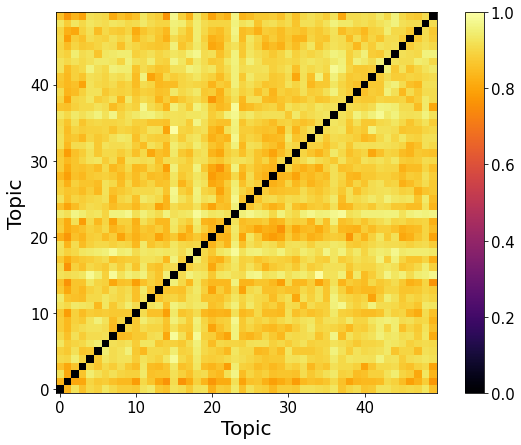

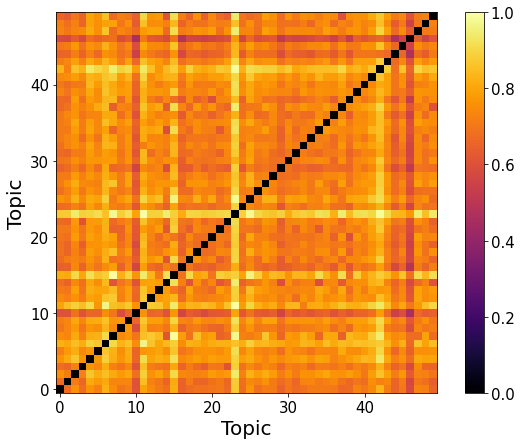

In [59]:
#checking distance from a model to itself
#jaccard
plot_difference_matplotlib(lda_by_year['2019'].diff(lda_by_year['2019'],distance="jaccard")[0])

#shannon-jensen
plot_difference_matplotlib(lda_by_year['2019'].diff(lda_by_year['2019'],distance="jensen_shannon")[0])

In [63]:
jaccard_topic_difference = {} 
jensen_shannon_topic_difference = {} 

for year in range(2000,2021):
    print(f"getting difference for year: {year}")
    #get forward difference between topics
    mdiff,annotations = lda_by_year[str(year+1)].diff(lda_by_year[str(year)],distance='jaccard',num_words=50)
    jaccard_topic_difference[year] = mdiff

    mdiff,annotations = lda_by_year[str(year+1)].diff(lda_by_year[str(year)],distance='jensen_shannon',num_words=50)
    jensen_shannon_topic_difference[year] = mdiff

getting difference for year: 2000
getting difference for year: 2001
getting difference for year: 2002
getting difference for year: 2003
getting difference for year: 2004
getting difference for year: 2005
getting difference for year: 2006
getting difference for year: 2007
getting difference for year: 2008
getting difference for year: 2009
getting difference for year: 2010
getting difference for year: 2011
getting difference for year: 2012
getting difference for year: 2013
getting difference for year: 2014
getting difference for year: 2015
getting difference for year: 2016
getting difference for year: 2017
getting difference for year: 2018
getting difference for year: 2019
getting difference for year: 2020


2023-07-26 15:30:14,007 : DEBUG : locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002308499FD30>
2023-07-26 15:30:14,007 : DEBUG : Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000002308499FD30> on colorbar
2023-07-26 15:30:14,007 : DEBUG : Setting pcolormesh


2023-07-26 15:30:14,053 : DEBUG : locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000023084364B80>
2023-07-26 15:30:14,053 : DEBUG : Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000023084364B80> on colorbar
2023-07-26 15:30:14,053 : DEBUG : Setting pcolormesh


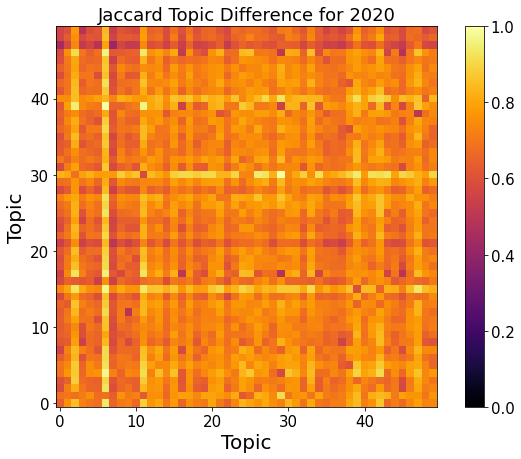

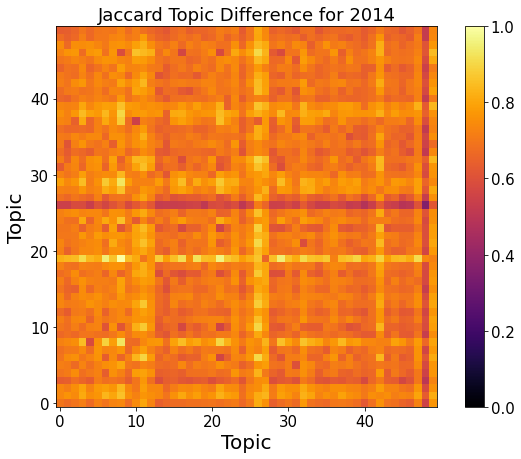

In [65]:
#plot difference in topics over time
year = 2020
plot_difference_matplotlib(jensen_shannon_topic_difference[year], title=f"Jaccard Topic Difference for {year}")


year = 2014
plot_difference_matplotlib(jensen_shannon_topic_difference[year], title=f"Jaccard Topic Difference for {year}")

In [73]:
def metric_by_year(data_dict,title=''):
    xs = sorted(list(data_dict.keys()))
    ys = [data_dict[x].sum()/(ntopics**2) for x in xs]

    fig = plt.figure(figsize=(8, 6))

    plt.scatter(xs,ys,s=100)
    plt.xlabel('Year',fontsize=25)
    plt.ylabel('Sum of Differences',fontsize=25)
    plt.title(title)
    plt.xticks(xs,[str(x) for x in xs],rotation='vertical')


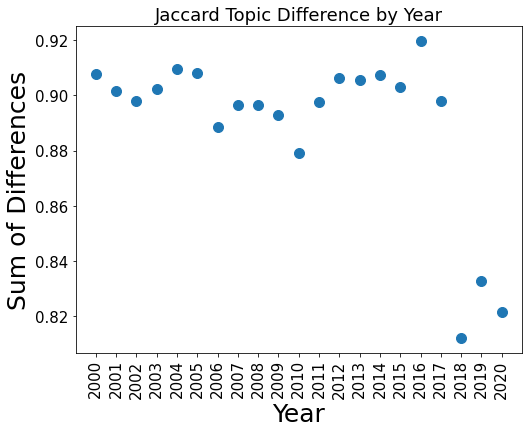

In [74]:
#plot difference in topics over time
metric_by_year(jaccard_topic_difference,'Jaccard Topic Difference by Year')


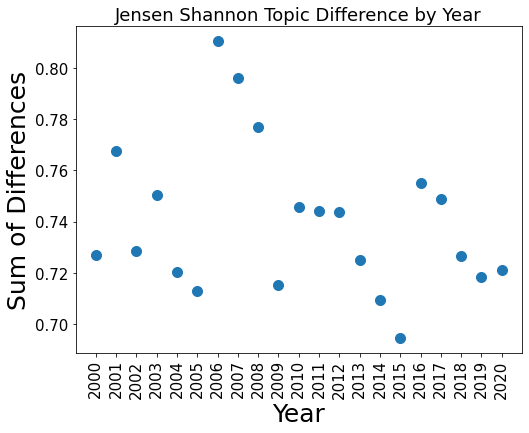

In [75]:
metric_by_year(jensen_shannon_topic_difference,'Jensen Shannon Topic Difference by Year')

### Funding Per Topic

In [76]:
year = '2020'
topic_dist = lda_by_year[year].get_document_topics(corpus_by_year[year],minimum_probability=0)

In [77]:
model.show_topics(num_topics=ntopics,num_words=5,formatted=False)

[(0,
  [('control', 0.019934354),
   ('manufacturing', 0.015885042),
   ('process', 0.01088838),
   ('time', 0.010065509),
   ('algorithm', 0.009152322)]),
 (1,
  [('material', 0.030639546),
   ('magnetic', 0.023304852),
   ('shape', 0.01954746),
   ('actuation', 0.017516283),
   ('soft', 0.015431589)]),
 (2,
  [('material', 0.013001002),
   ('gel', 0.009975737),
   ('property', 0.0075297896),
   ('mechanical', 0.007421867),
   ('dynamic', 0.0069266874)]),
 (3,
  [('data', 0.018066373),
   ('control', 0.015396235),
   ('cloud', 0.009434536),
   ('learning', 0.008631606),
   ('process', 0.0072295237)]),
 (4,
  [('data', 0.0154532585),
   ('soft', 0.01349931),
   ('material', 0.0129837785),
   ('learning', 0.009879195),
   ('test', 0.009785389)]),
 (5,
  [('structural', 0.021071035),
   ('building', 0.018213192),
   ('earthquake', 0.015593406),
   ('performance', 0.012140879),
   ('structure', 0.011037938)]),
 (6,
  [('traffic', 0.07342701),
   ('vehicle', 0.0541208),
   ('control', 0.03

In [ ]:
#funding per topic for each year
def funding_per_topic(data,lda_by_year,year):
    #get topic distribution for each abstract
    topic_dist = lda_by_year[year].get_document_topics(corpus_by_year[year],minimum_probability=0)
